In [1]:
# import
import numpy as np
import scipy
from itertools import cycle
import matplotlib as mpl
import matplotlib.pyplot as plt

from helper_func import delay_webster

In [2]:
# environment
q = np.array([[240,240],[240,240],[240,240],[240,240]])
s = 1800
r = 2  # all red
a = 3  # amber light
t = 3  # time loss of start and end 
phase = np.array([[0,1],[-1,-1],
                  [2,3],[-1,-1],
                  [4,5],[-1,-1],
                  [6,7],[-1,-1]]) # 单口放行, 包括绿灯间隔相位

In [235]:
# fixed-time
g_time = 40.0
g = g_time*np.ones(4).astype(int)  # 绿灯时间
print(g)

phase_time = np.stack([g+a-t,(t+r)*np.ones(4)],axis=0).swapaxes(0,1).reshape(-1).astype(int)  # 相位时间

phase_sequence = np.repeat(phase,phase_time,axis=0)
phase_sequence = cycle([phase_sequence[i] for i in range(len(phase_sequence))])

[40. 40. 40. 40.]


In [237]:
# webster's (approximation)
y_r = (q/s).max(axis=-1)  # 对应于单口放行的流量比计算
Y = y_r.sum()
L = 4*(t+r)
if Y > 0.8:
    y_r = y_r/Y*0.8
    Y = 0.8
C = (1.5*L+5.0)/(1-Y)
g = (C-L)*y_r/Y  # 有效绿灯时间
g = (g+t-a).astype(int)  # 绿灯时间
print(g)
phase_time = np.stack([g+a-t,(t+r)*np.ones(4)],axis=0).swapaxes(0,1).reshape(-1).astype(int)  # 相位时间

phase_sequence = np.repeat(phase,phase_time,axis=0)
phase_sequence = cycle([phase_sequence[i] for i in range(len(phase_sequence))])

[21 21 21 21]


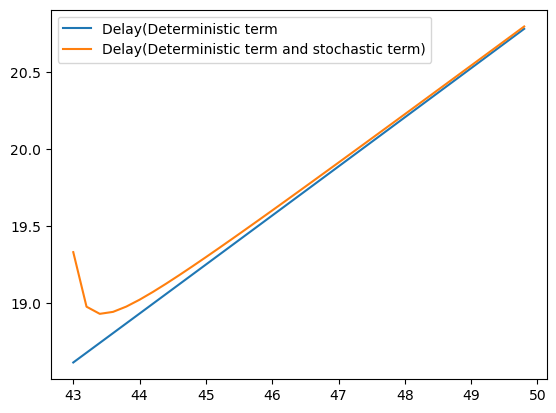

In [10]:
# webster's (optimum)
y_r = (q/s).max(axis=-1)
Y = y_r.sum()
L = 4*(t+r)
if Y > 0.8:
    y_r = y_r/Y*0.8
    Y = 0.8
C_max = 50
C_min = np.ceil(L/(1-Y)).astype(int)
C_arr = np.arange(C_min,C_max,0.2)
num_C = len(C_arr)
sigma_arr = C_arr*Y/(C_arr-L)
# print(sigma_arr)
delay_arr = np.zeros(num_C)
delay_arr_2 = np.zeros(num_C)
for i,sigma in enumerate(sigma_arr):
    delay_arr[i] = delay_webster(y_r,s,L,sigma,is_stochastic=False)
    delay_arr_2[i] = delay_webster(y_r,s,L,sigma,is_stochastic=True)
# C = C_arr[np.argmin(delay_arr)]

fig,ax = plt.subplots()
ax.plot(C_arr,delay_arr,label='Delay(Deterministic term)')
ax.plot(C_arr,delay_arr_2,label='Delay(Deterministic term and stochastic term)')
ax.legend()

# g = (C-L)*y_r/Y  # 有效绿灯时间
# g = g+t-a  # 绿灯时间
# print(g)
# phase_time = np.stack([g+a-t,(t+r)*np.ones(4)],axis=0).swapaxes(0,1).reshape(-1) # 相位时间
# phase_time = np.ceil(phase_time).astype(int)

# phase_sequence = np.repeat(phase,phase_time,axis=0)
# phase_sequence = cycle([phase_sequence[i] for i in range(len(phase_sequence))])

In [ ]:
# Q-learning
q_value = np.zeros((2*120,2))  # (state,action)


In [240]:
# point queue model
step_length = 1.0  # 步长调整未实现
sim_length = 1800  # simulation duration in seconds
step_num = np.ceil(sim_length/step_length).astype(int)
q_record = np.zeros((step_num,4,2))  # 交叉口当前排队
q_state = np.zeros((4,2))
for i in range(step_num):
    flag = np.zeros(8)
    p = next(phase_sequence)
    if p[0]>=0 and p[1]>=0:
        flag[p] = 1.0
    q_state += q/3600 - s/3600*flag.reshape((4,2))
    np.place(q_state,q_state<0,0)
    q_record[i] = q_state[:]
np.save('./exp1/webster-revised-b.npy',q_record)

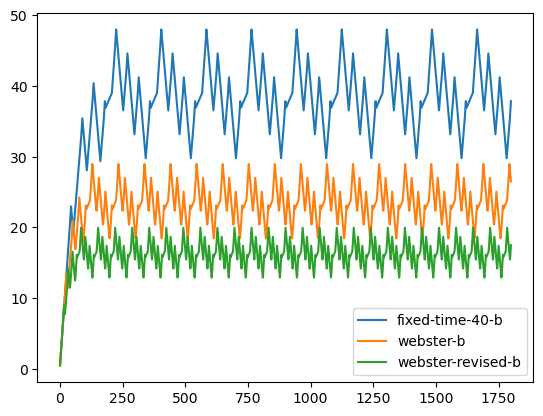

In [241]:
names = ['fixed-time-40-b','webster-b','webster-revised-b']
q_res = {}
for name in names:
    q_res[name] = np.load('./exp1/'+name+'.npy')

fig,ax = plt.subplots()
for name in names:
    ax.plot(q_res[name].sum((-1,-2)),label=name)
    # ax.plot(q_res[name][:,1,:],label=name)
ax.legend()